## MATHCO.THON

OBJECTIVE : With the rise in the variety of cars with differentiated capabilities and features such as model, production year, category, brand, fuel type, engine volume, mileage, cylinders, colour, airbags and many more, we are bringing a car price prediction challenge for all. We all aspire to own a car within budget with the best features available


In [260]:
# Import modules


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer
from category_encoders import JamesSteinEncoder,TargetEncoder
from sklearn.model_selection import KFold

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor



from sklearn.metrics import mean_squared_log_error

import joblib
from warnings import filterwarnings
filterwarnings('ignore')

In [225]:
# load the data
train = pd.read_csv(r"../input/train.csv")
test = pd.read_csv(r"../input/test.csv")
sub = pd.read_csv("../input/submission.csv")

print(f"shape of train data {train.shape}")
print(f"shape of test data {test.shape}")

shape of train data (19237, 18)
shape of test data (8245, 18)


In [226]:
## Check for duplicate in train file based on id
print(f"Found {train['ID'].duplicated().sum()} duplicate ID's in Data")

# remove Duplicate
train = train.drop_duplicates(subset='ID', keep="first")

print(f"\nFound {train['ID'].duplicated().sum()} duplicate ID's in Data")


# Combine the data for further process
train['isTrain'] = 1
test['isTrain'] = 0
data = train.append(test)
data = data.drop("ID",axis=1)

print(f"shape of final data {data.shape}")

Found 313 duplicate ID's in Data

Found 0 duplicate ID's in Data
shape of final data (27169, 18)


In [227]:
def basic_data_cleaning(df):
    
    df['Levy'] = df['Levy'].replace("-",np.nan)
    data['Mileage'] = data['Mileage'].apply(lambda x:x.split(" ")[0])
    data['Mileage'] = data['Mileage'].astype(float)
    
    # Engine volume treatment
    data['isTurbo'] = data['Engine volume'].apply(lambda x : 1 if "Turbo" in x else 0 )
    data['Engine volume'] = data['Engine volume'].apply(lambda x : x.split(" ")[0] if "Turbo" in x else x)
    data['Engine volume'] = data['Engine volume'].astype("float")
    data['Engine volume'] = data['Engine volume']*1000
    data["Engine volume"].replace(0,np.nan,inplace=True)
    
    # Doors
    data['Doors'] = data['Doors'].apply(lambda x : x.replace("04-May","04-05") if "May" in x else x)
    data['Doors'] = data['Doors'].apply(lambda x : x.replace("02-Mar","02-03") if "Mar" in x else x)
    
    # Model
    data['Manufacturer'] = data['Manufacturer'].apply(lambda x : x.lower())
    data['Model'] = data['Model'].apply(lambda x : x.lower())
    
    # Data column name change
    data.columns = [col.replace(" ","_") for col in data.columns]
    
    return data



data = basic_data_cleaning(data)

In [228]:
## Null value Summary

# gives some infos on columns types and numer of null values
data_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values'}))
data_info=data_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print("*"*80)
print("Data Null value Report\n")
display(data_info)


## Filling null values
fill_feats = ['Levy','Engine_volume']

'''
Hypothesis for Null values
Levy Values and Engine volume highly depends on Model and Manufacturer

'''

for feat in fill_feats:
    data[feat] = data[feat].fillna(data.groupby(['Manufacturer','Model'])[feat].transform('median'))
    data[feat] = data[feat].fillna(data.groupby(['Manufacturer'])[feat].transform('median'))
    data[feat] = data[feat].fillna(data[feat].median())            



    
data_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
data_info=data_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values'}))
data_info=data_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
print("*"*80)
print("Data Null value Report after Null value Treatment \n")
display(data_info)

********************************************************************************
Data Null value Report



,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,isTrain,isTurbo
column type,float64,float64,object,object,int64,object,object,object,float64,float64,int64,object,object,object,object,object,int64,int64,int64
null values,8245,8163,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0
null values (%),30.3471,30.0453,0,0,0,0,0,0,0.05521,0,0,0,0,0,0,0,0,0,0


********************************************************************************
Data Null value Report after Null value Treatment 



,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,isTrain,isTurbo
column type,float64,float64,object,object,int64,object,object,object,float64,float64,int64,object,object,object,object,object,int64,int64,int64
null values,8245,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),30.3471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Data Exploration

<Figure size 1440x576 with 0 Axes>

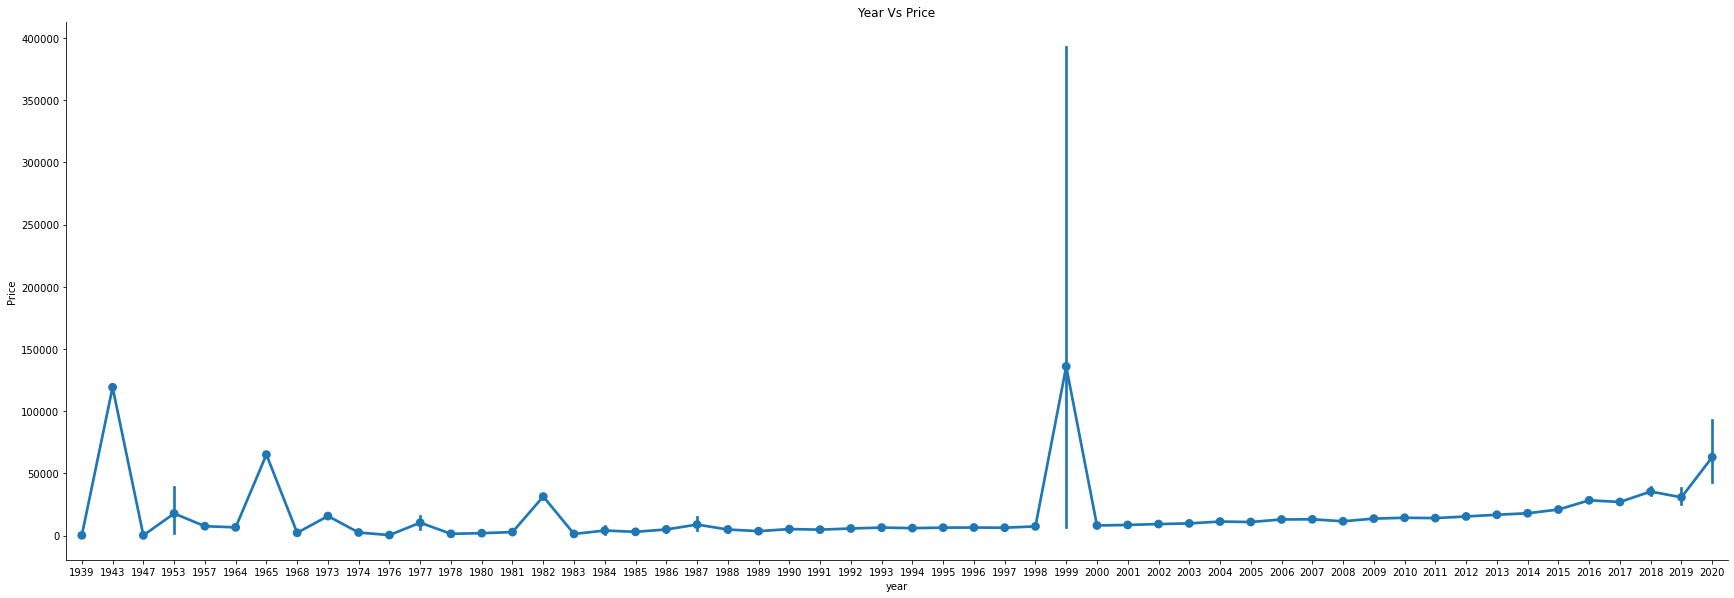

In [189]:
plt.figure(figsize=(20,8))
mx = sns.factorplot(x="Prod. year", y="Price", data=train, size=8 ,aspect=3)
mx.set(xlabel= 'year')
mx.set(ylabel= 'Price')
plt.title('Year Vs Price');
plt.show();

* We can observe that there is one outlier in year 1999

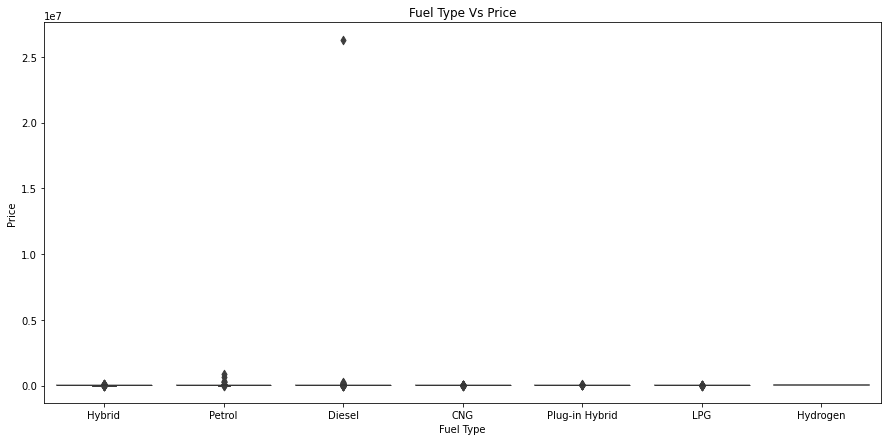

In [57]:
plt.figure(figsize=(15,7))
mx = sns.boxenplot(x="Fuel type", y="Price", data=train)
mx.set(xlabel= 'Fuel Type')
mx.set(ylabel= 'Price')
plt.title('Fuel Type Vs Price');
plt.show();

We have One  outlier data point in Diesel category

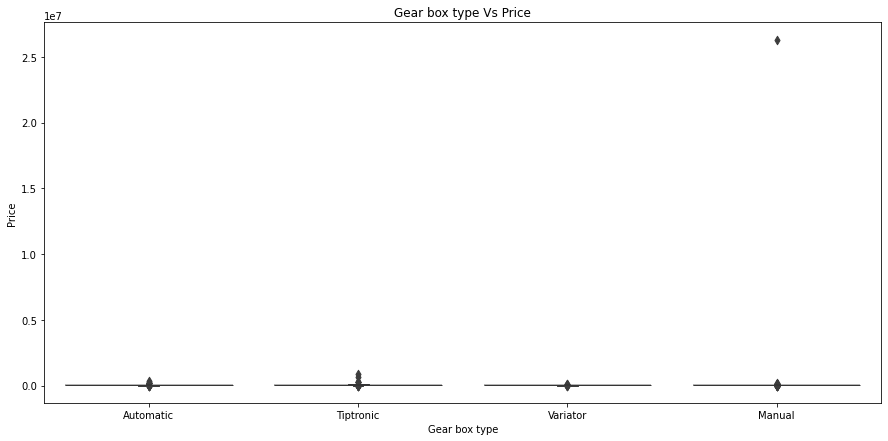

In [58]:
plt.figure(figsize=(15,7))
mx = sns.boxenplot(x="Gear box type", y="Price", data=train)
mx.set(xlabel= 'Gear box type')
mx.set(ylabel= 'Price')
plt.title('Gear box type Vs Price');
plt.show();

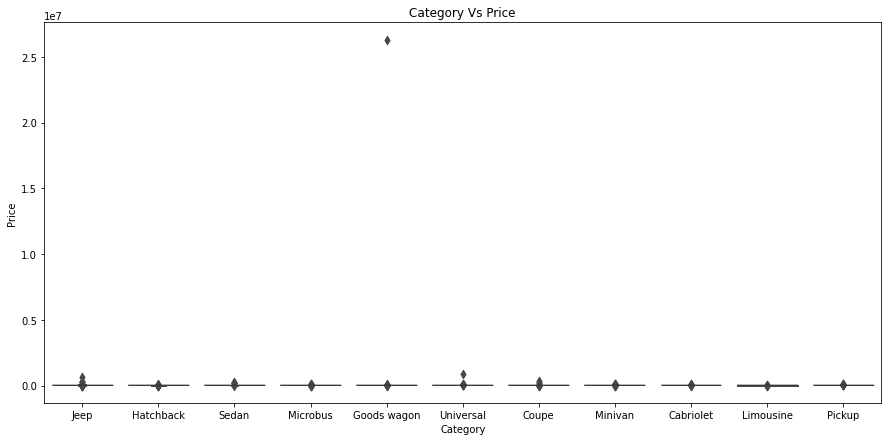

In [59]:
plt.figure(figsize=(15,7))
mx = sns.boxenplot(x="Category", y="Price", data=train)
mx.set(xlabel= 'Category')
mx.set(ylabel= 'Price')
plt.title('Category Vs Price');
plt.show();

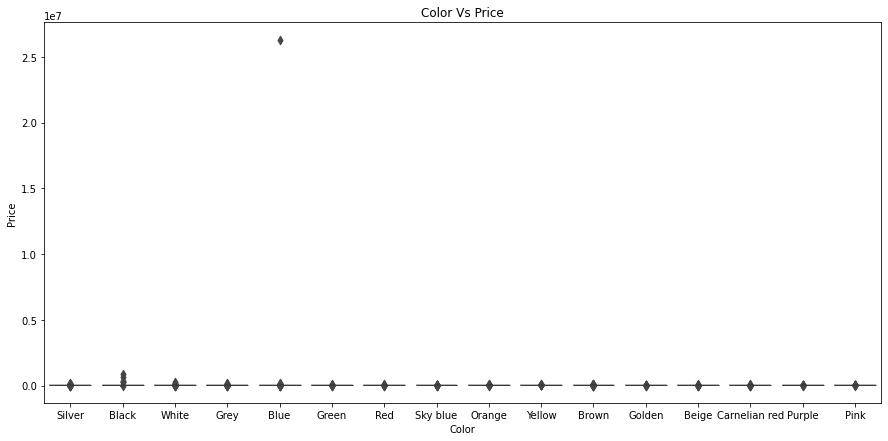

In [60]:
plt.figure(figsize=(15,7))
mx = sns.boxenplot(x="Color", y="Price", data=train)
mx.set(xlabel= 'Color')
mx.set(ylabel= 'Price')
plt.title('Color Vs Price');
plt.show();

*SO far we observed the one outlier point in all visualization, so let's check*

In [78]:
data[(data['Color']=='Blue') & (data['Gear_box_type']=='Manual') & (data['Category']=='Goods wagon') & (data['Fuel_type'] == 'Diesel')
    & (data['Prod._year'] ==1999)]

,Price,Levy,Manufacturer,Model,Prod._year,Category,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box_type,Drive_wheels,Doors,Wheel,Color,Airbags,isTrain,isTurbo
2503,5000.0,1053.0,opel,astra,1999,Goods wagon,No,Diesel,2000.0,0,4,Manual,Front,04-05,Left wheel,Blue,4,1,1
9042,10976.0,1408.0,ford,transit,1999,Goods wagon,No,Diesel,2500.0,137000,4,Manual,Rear,04-05,Left wheel,Blue,2,1,0
16983,26307500.0,1437.0,opel,combo,1999,Goods wagon,No,Diesel,1700.0,99999,4,Manual,Front,02-03,Left wheel,Blue,0,1,0
4250,NaN,1053.0,opel,astra,1999,Goods wagon,No,Diesel,1700.0,200000,4,Manual,Front,04-05,Left wheel,Blue,6,0,1


<AxesSubplot:xlabel='Mileage'>

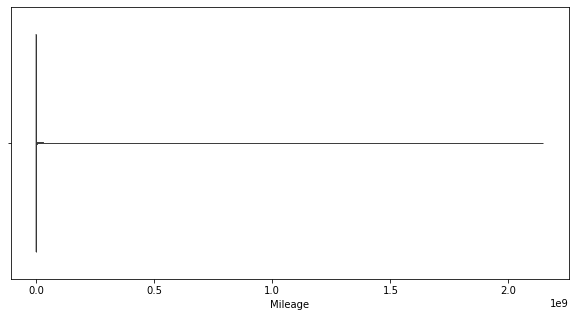

In [101]:
plt.figure(figsize=(10,5))
sns.boxenplot(x=data["Mileage"])

#### Mileage has skewed Distribution

In [229]:
# # Replacing this outlier with median value
median = train.loc[train['Price']!=26307500.0, 'Price'].median()
data['Price'] = np.where(data['Price']==26307500.0,median,data['Price'])

# Mileage
median = data.loc[data['Mileage']!=999999999, 'Mileage'].median()
data['Mileage'] = np.where(data['Mileage']==999999999,median,data['Mileage'])

# Prod Year (1939 Prod year not in test data set)
data = data[data['Prod._year'] != '1939']

### Feature Engineering

In [230]:
#### Fuel Type Treatment
fuel_map = {"Plug-in Hybrid":"Hybrid","LPG":"Gas","CNG":"Gas","Hydrogen":"Gas",
            "Petrol":"Petrol","Diesel":"Diesel","Hybrid":"Hybrid"}

data['Fuel_type'] = data['Fuel_type'].map(fuel_map)

In [231]:
# car age
data['age'] = 2021 - data['Prod._year']

In [232]:
# Engine Power (Depends on Engine volume and Number of cylinder)
data['Power']  = round(data['Engine_volume']/data['Cylinders'],1)

#kmil driven per year
data['Kmperyear'] = round(data['Mileage']/data['age'],0)

# Engine power per year
data['powPeryear'] = round(data['Power']/data['age'],0)

# total tax paid per year
data['LevyPeryear'] = round(data['Levy']/data['age'],0)


In [233]:
'''
Following features are left skewed, used log transformation, Also try Box-cox but log transformation
give me better results
'''

data['Mileage'] = round(np.log1p(data['Mileage']),3)
data['Levy'] = round(np.log1p(data['Levy']),3)
data['age'] = round(np.log1p(data['age']),3)
data['Power'] = round(np.log1p(data['Power']),3)
data['Engine_volume'] = round(np.log1p(data['Engine_volume']),3)
data['Kmperyear'] = round(np.log1p(data['Kmperyear']),3)                       
data['powPeryear'] = round(np.log1p(data['powPeryear']),3)
data['LevyPeryear']  = round(np.log1p(data['LevyPeryear']),3)

In [234]:
### Statstical Features based on Model and Manufactrer

data['Avg_model_milege'] = data.groupby(['Model'])['Mileage'].transform('median')
data['Avg_manu_milege'] = data.groupby(['Manufacturer'])['Mileage'].transform('median')

data['Avg_LV_manu'] = data.groupby(['Manufacturer'])['Levy'].transform('median')
data['Avg_LV_model'] = data.groupby(['Model'])['Levy'].transform('median')


data['Avg_power_model'] = data.groupby(['Manufacturer'])['Power'].transform('median')
data['Avg_power_manu'] = data.groupby(['Model'])['Power'].transform('median')

data['Category_count_manu'] = data.groupby(['Manufacturer'])['Category'].transform('nunique')
data['Category_count_model'] = data.groupby(['Model'])['Category'].transform('nunique')

In [235]:
### Few Feature based on binning count

'''
This way data of feature are more uniformly distribtuted
'''

cont_features = ['Levy','Mileage','age','Power','Kmperyear','powPeryear']

for cont_feat in cont_features:
    discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')
    feature_name = cont_feat+"_"+"bins"
    data[feature_name] = discretizer.fit_transform(data[cont_feat].values.reshape(-1,1)).astype(int)


In [236]:
# Cylinder Treatment
bins = [0,4,8,300]
labels = ["<=4","<=8",">=12"]

data['Cylinders'] = pd.cut(data["Cylinders"],bins=bins,labels=labels,right=True)

#### Encoding Techniques for Categorical Variables

1. For Model and Manufacturer, I have decide to Use Target Encoding & JamesSteinEncoding
2. Rest of All categorical variable i used Mean Encoding

In [237]:
# Mean Encoding

temp = data[data['isTrain']==1]
temp["Price"] = np.log1p(temp['Price'])


cat_feat = ['Category','Leather_interior','Fuel_type','Cylinders','Gear_box_type',
           'Drive_wheels','Doors','Wheel','Color','Airbags']

for feat in cat_feat:
    feat_mean = temp.groupby(feat)["Price"].mean()
    data[feat] = round(data[feat].replace(feat_mean.index,feat_mean.values),2)

In [238]:
# Spliting test and train data
final_data = data.copy()
train_df = final_data[final_data['isTrain']==1]
test_df = final_data[final_data['isTrain']==0]
train_df = train_df.drop('isTrain',axis=1)
test_df = test_df.drop('isTrain',axis=1)
train_df['Price'] = np.log1p(train_df['Price'])
test_df.drop(['Price'],axis=1,inplace=True)

In [239]:
### Target Encoding

X = train_df.drop(labels=['Price'], axis=1)
y = train_df['Price']
cat_features = ['Model','Manufacturer']

# use target encoding to encode two categorical features
enc = JamesSteinEncoder(cols=cat_features)

# transform the datasets
train_df = round(enc.fit_transform(X,y.values),2)
test_df = round(enc.transform(test_df),2)


## Saving Pickle file for future use

joblib.dump(train_df,"trans_train_file.bin")
joblib.dump(test_df,"trans_test_file.bin")

['trans_test_file.bin']

### Modelling

#### Light GB

[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
****************************************************************************************************
RMSLE score for fold 1 is 0.9807907143637814
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
****************************************************************************************************
RMSLE score for fold 2 is 0.940260984175679
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
****************************************************************************************************
RMSLE score for fold 3 is 0.8896487126182111
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
***************************************************************************************

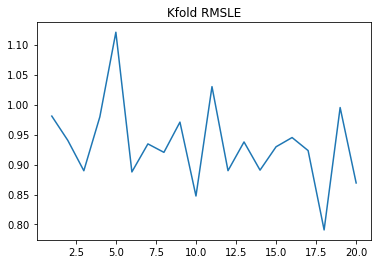

In [257]:
# 20 fold cross validation for Light GB

kf = KFold(n_splits=20, shuffle=True)

scores = {}
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y), 1):
    
    X_train = train_df.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = train_df.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    model = lgb.LGBMRegressor(n_estimators=1000, max_depth=15, learning_rate=0.05, num_leaves=44,
                               max_bin = 30, bagging_fraction = 0.78)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_val)
 
    score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1((pred))))
    
    print("*"*100)
    print(f'RMSLE score for fold {fold} is {score}')
    scores.update({fold:score})
    
print("*"*150)
print(f'Mean RMSLE score is {np.mean(list(scores.values()))}')

plt.plot(scores.keys(),scores.values())
plt.title("Kfold RMSLE")
plt.show()

#### XGBOOST

****************************************************************************************************
RMSLE score for fold 1 is 0.8913452425572034
****************************************************************************************************
RMSLE score for fold 2 is 0.8419384516628261
****************************************************************************************************
RMSLE score for fold 3 is 0.8427337270724246
****************************************************************************************************
RMSLE score for fold 4 is 0.8895037190259071
****************************************************************************************************
RMSLE score for fold 5 is 0.9774340788340877
****************************************************************************************************
RMSLE score for fold 6 is 0.97758221542017
****************************************************************************************************
RMSLE score for fold 7 is

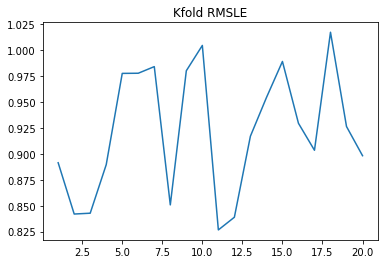

In [259]:
# 20 fold cross validation for xgBoost

kf = KFold(n_splits=20, shuffle=True)

scores = {}
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y), 1):
    
    X_train = train_df.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = train_df.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    model = xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror', max_depth=15, learning_rate=0.05, min_child_weight=1.2,
                            colsample_bytree=0.6, reg_alpha=0.001)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_val)
 
    score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1((pred))))
    
    print("*"*100)
    print(f'RMSLE score for fold {fold} is {score}')
    scores.update({fold:score})
    
print("*"*150)
print(f'Mean RMSLE score is {np.mean(list(scores.values()))}')

plt.plot(scores.keys(),scores.values())
plt.title("Kfold RMSLE")
plt.show()

#### Extra Tree Regression

****************************************************************************************************
RMSLE score for fold 1 is 1.030020922536638
****************************************************************************************************
RMSLE score for fold 2 is 0.9464681559022404
****************************************************************************************************
RMSLE score for fold 3 is 0.8700108058078216
****************************************************************************************************
RMSLE score for fold 4 is 0.8988032411356477
****************************************************************************************************
RMSLE score for fold 5 is 0.8376831054021083
****************************************************************************************************
RMSLE score for fold 6 is 0.8818141249824429
****************************************************************************************************
RMSLE score for fold 7 i

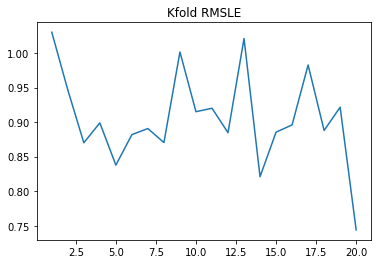

In [261]:
# 20 fold cross validation for xgBoost

kf = KFold(n_splits=20, shuffle=True)

scores = {}
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y), 1):
    
    X_train = train_df.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = train_df.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    model = ExtraTreesRegressor(n_estimators=500, bootstrap=True, n_jobs=-1)
    
    model.fit(X_train, y_train)
    
    pred = model.predict(X_val)
 
    score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1((pred))))
    
    print("*"*100)
    print(f'RMSLE score for fold {fold} is {score}')
    scores.update({fold:score})
    
print("*"*150)
print(f'Mean RMSLE score is {np.mean(list(scores.values()))}')

plt.plot(scores.keys(),scores.values())
plt.title("Kfold RMSLE")
plt.show()

#### Model Blending

[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
******************************************************************************************************************************************************
RMSLE score for fold 1 is 0.8450157981623612
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
******************************************************************************************************************************************************
RMSLE score for fold 2 is 0.8798457735733441
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
******************************************************************************************************************************************************
RMSLE score for fold 3 is 0.9492708107182812
[LightGBM] [Warning] bagging_fraction is set=0.78, subs

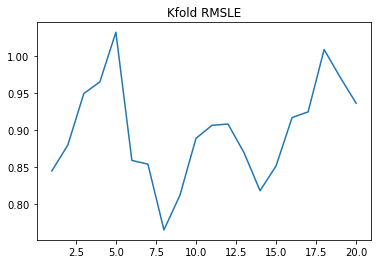

In [263]:
# K-Fold Cross Validation 
#X = training_numeric_dataset
test = test_df

test_results = []

kf = KFold(n_splits=20, shuffle=True)
scores = {}
for fold, (train_idx, val_idx) in enumerate(kf.split(train_df, y), 1):
    
    X_train = train_df.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_val = train_df.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    model1 =  xgb.XGBRegressor(n_estimators=1000, objective='reg:squarederror', max_depth=15, learning_rate=0.05, min_child_weight=1.2,
                            colsample_bytree=0.6, reg_alpha=0.001)
    
    model2 = lgb.LGBMRegressor(n_estimators=1000, max_depth=15, learning_rate=0.05, num_leaves=34,
                              max_bin = 30, bagging_fraction = 0.78)
    
    model3 = ExtraTreesRegressor(n_estimators=500, bootstrap=True, n_jobs=-1)

    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    
    
    pred1 = model1.predict(X_val)
    pred2 = model2.predict(X_val)
    pred3 = model3.predict(X_val)
    
    pred = 0.2*pred1 + 0.1*pred2 + 0.7*pred3 
    
    test_preds1 = model1.predict(test)
    test_preds2 = model2.predict(test)
    test_preds3 = model3.predict(test)
    
    test_preds = 0.2*test_preds1 + 0.1* test_preds2 + 0.7*test_preds3
    
    test_results.append(test_preds)
 
    score = np.sqrt(mean_squared_log_error(np.expm1(y_val), np.expm1((pred))))
    print("*"*150)
    print(f'RMSLE score for fold {fold} is {score}')
    scores.update({fold:score})

print("*"*150)
print(f'Mean RMSLE score is {np.mean(list(scores.values()))}')

plt.plot(scores.keys(),scores.values())
plt.title("Kfold RMSLE")
plt.show()

### Submission

In [264]:
blending_final = np.expm1(np.mean(test_results,0))
sub['Price']= blending_final
sub.to_csv('Final_submission.csv',index=False)

In [265]:
sub['Price'].describe()

count      8245.000000
mean      14289.302924
std       14434.953050
min          29.530465
25%        4235.999779
50%       10884.127809
75%       18525.099125
max      182611.010253
Name: Price, dtype: float64

#### Saving model files

In [268]:
joblib.dump(model1,"XGBOOST.bin")
joblib.dump(model2,"LGBM.bin")
joblib.dump(model3,"ETR.bin")

['ETR.bin']